# Discrete Hopfield Network Demo for Image Reconstruction

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/attractors/discrete_hopfield_demo_for_image_reconstruction.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/examples/blob/main/attractors/discrete_hopfield_demo_for_image_reconstruction.ipynb)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import brainpy as bp
import brainpy.math as bm

In [16]:
bp.__version__ 

'2.4.5.post4'

For the mathematical foundation of the discrete Hopfield network, please see [our previous tutorial](./discrete_hopfield_network.ipynb). 

## Data for testing

Now we are going to load the data in. I have already saved off two images, a '9' and a '4', to keep things simple for us. We also reshape them into their native [28 x 28] size, so that we can later corrupt them in this domain, and then reconstruct them.

The data can be downloaded in this url: https://github.com/brainpy/examples/blob/main/attractors/data/data_to_train_on.npy

In [17]:
data = (np.load('data/data_to_train_on.npy')).astype(np.float32)

data.shape

(2, 784)

What does our data look like? Well they are just two binary images, showing a figure '9', and a figure '4'. Let's image them just to take a peek at what they look like.

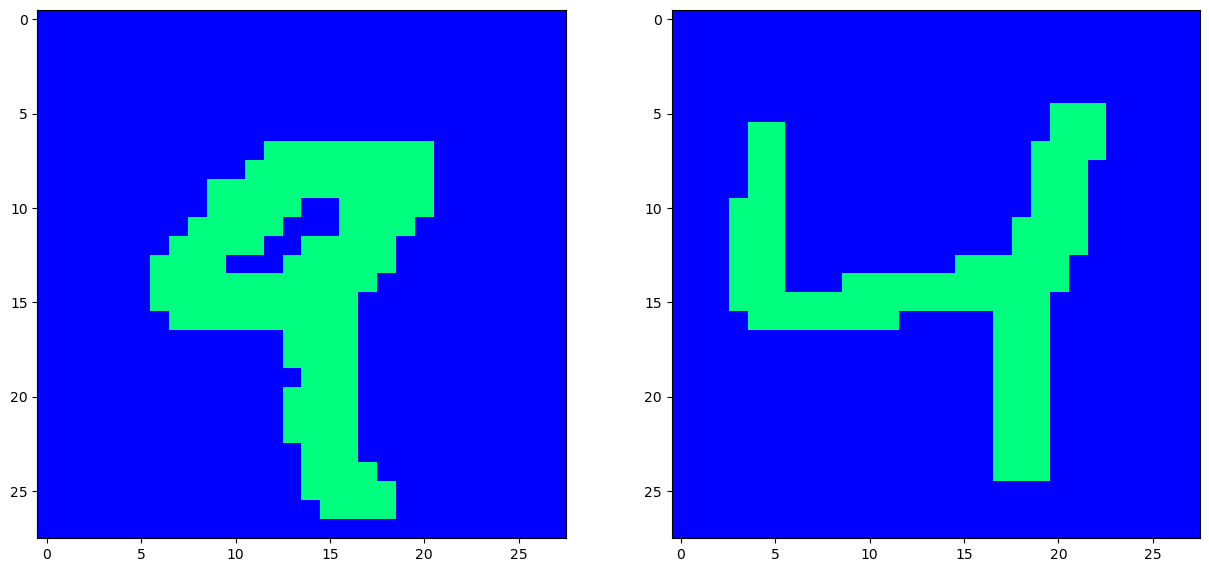

In [18]:
# Show the training data - it's just two different samples that we are going to want the Hopfield net to store.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(data[0].reshape(28, 28), interpolation='None', cmap='winter')
ax[1].imshow(data[1].reshape(28, 28), interpolation='None', cmap='winter')
plt.show()

We will use this function to take in a good image, and corrupt it, based on two types of noise, either bernouli noise, (where every pixel is randomly flipped in sign), or masking noise, where we blot out entire sections of the image. Our Hopfield net will be able to recover the original image via energy minimization as we will see.

In [19]:
def add_bernouli_noise(img, prob=0.1, mask_value=1.):
    rand = np.random.rand(*img.shape) < prob
    return np.where(rand, mask_value, img)

In [20]:
def add_mask_noise(img, mask_value=-1, mask_matrix=np.zeros((2,2))):
    img = np.copy(img)
    img[mask_matrix[0,0]: mask_matrix[0,1], mask_matrix[1,0]: mask_matrix[1,1]] = mask_value
    return img

## Models

We use our implementation in [Discrete Hopfield Network](./discrete_hopfield_network.ipynb). 

In [21]:
class HopfieldNet(bp.DynamicalSystem):
  def __init__(self, num):
    super().__init__()
    self.num = num
    self.weight = bm.Variable(bm.zeros([num, num]))

  # Train function for the Hopfield net. (By updating the weights)
  @bm.cls_jit
  def store_patterns(self, samples):
    # data: An array with [d, N]. 'd' is the number of data samples used to train. (In this case 2)
    assert samples.ndim == 2
    assert samples.shape[1] == self.num

    # Loop through all data samples.
    bm.for_loop(self.store, samples)

    # Hopfield nets are a form of RNNs, albeit without self-connections, and so,
    # we need to make sure that the diagonal elements of the final weight matrix are zero.
    bm.fill_diagonal(self.weight, 0)

  # Storing one sample pattern
  @bm.cls_jit
  def store(self, sample):
    # sample is an array with the shape of (N,)
    assert self.num == sample.shape[0]

    # Data cross-product gives neural hopfield update rule.
    w_update = bm.outer(sample, sample)

    # Sum all pattern cross-products.
    self.weight += w_update

  def async_recover(self, sample, n, energy=False):
    # n: the number of iterations to recover
    # energy: calculate the energy function
    idxs = bm.random.randint(0, self.num, n)  # the sampled positions
    # JIT compilation requires to label the value to be changed as Variable
    sample = bm.Variable(sample)

    def recover(i):
      # i: the position to update
      # update
      sample[i] = bm.sign(bm.inner(self.weight[i], sample))
      # return energy
      if energy:
        return self.energy(sample)

    r = bm.for_loop(recover, idxs) # for loop JIT
    return (sample, r) if energy else sample

  def sync_recover(self, sample, n, energy=False):
    # n: the number of iterations to recover
    # energy: calculate the energy function
    idxs = bm.arange(n)  # the update times
    # JIT compilation requires to label the value to be changed as Variable
    sample = bm.Variable(sample)

    def recover(i):
      # i: the position to update
      # update
      sample.value = bm.sign(self.weight @ sample)
      # return energy
      if energy:
        return self.energy(sample)

    r = bm.for_loop(recover, idxs)  # for loop JIT
    return (sample, r) if energy else sample

  # This function computes the Hopfield nets' energy.
  def energy(self, x):
    # x: [N] data vector
    return bm.inner(- x @ self.weight, x)

## Training

OK this is where the fun begins! We are now going to train our Hopfield net. The objective is simple: We want it to store those two patterns we are feeding it, such that a faithful reconstruction can be performed, when corrupted versions of either of those inputs is given later in the future.

In [22]:
# Train the Hopfield net! 

# So there are as many neurons as pixels per pattern, and this is what this computes.
net = HopfieldNet(num=data.shape[1])

# Great - we are all set - now we train! 
net.store_patterns(data)

Now at this point, we have a trained weight matrix, encoded with the pattern '4' and pattern '9'. (We will see later on that Hopfield nets aren't that memory efficient, but it's still amazing what they are capable of). Now remember - the objective here is simple: We want it to store those two patterns we are feeding it, such that faithful reconstruction can later be performed, when corrupted versions of either of those inputs are presented. But does it work? Let's find out!).

## Testing

We can corrupt our data in many ways - and here, we can add two types of noise: Bernouli noise, (where every pixel is flipped in sign with a certain probability) and/or masking noise, (where we simply blot out certain regions with one particular sign).

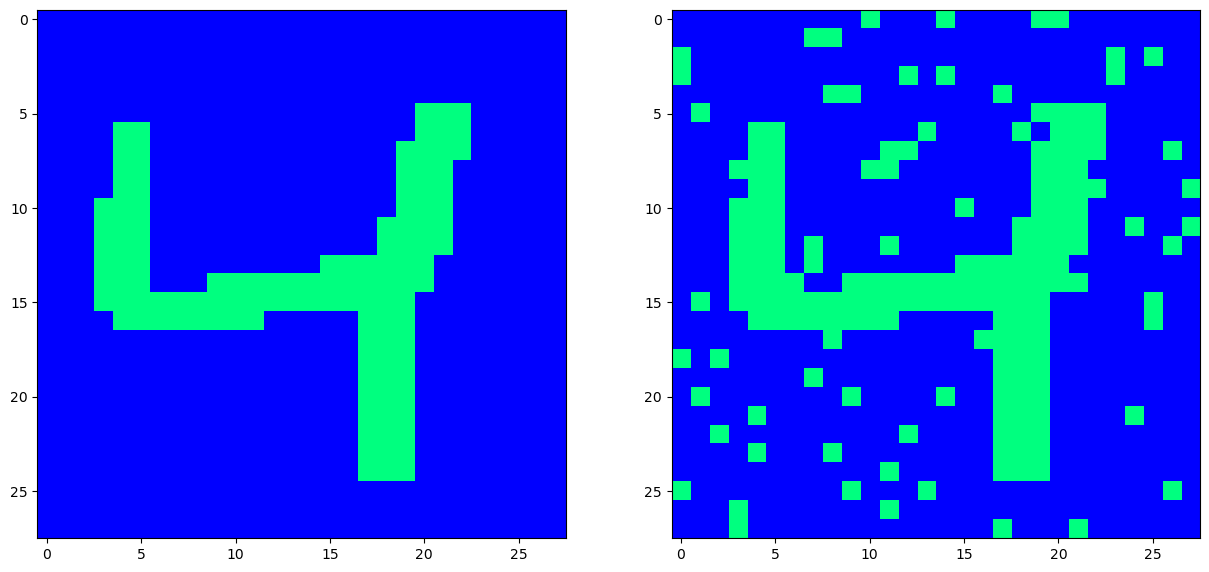

In [23]:
# Let's pick one the image '4', and corrupt it.
image = data[1]

# Corrupt the image with bernouli noise.
corrupted_image = add_bernouli_noise(image, prob=0.1)

# Let's see the original image, as well as the corrupted version.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(image.reshape(28, 28), interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image.reshape(28, 28), interpolation='None', cmap='winter')
plt.show()

This is the moment of truth: With a corrupted input now at hand, we then present this to our trained net, and hope that it denoises it. We do so by picking pixels at random, and then evaluating their activation functions, based on the current input configuration, (corrupted image), and the set weights, (that do not change here, as the net has already been trained).

Since the Hopfield net stores patterns as minimal enery states, every iteration where we update a neuron/pixel should place the net into a lower energy configuration - that is - closer to the original pattern we stored - the weights are designed to do so after all.

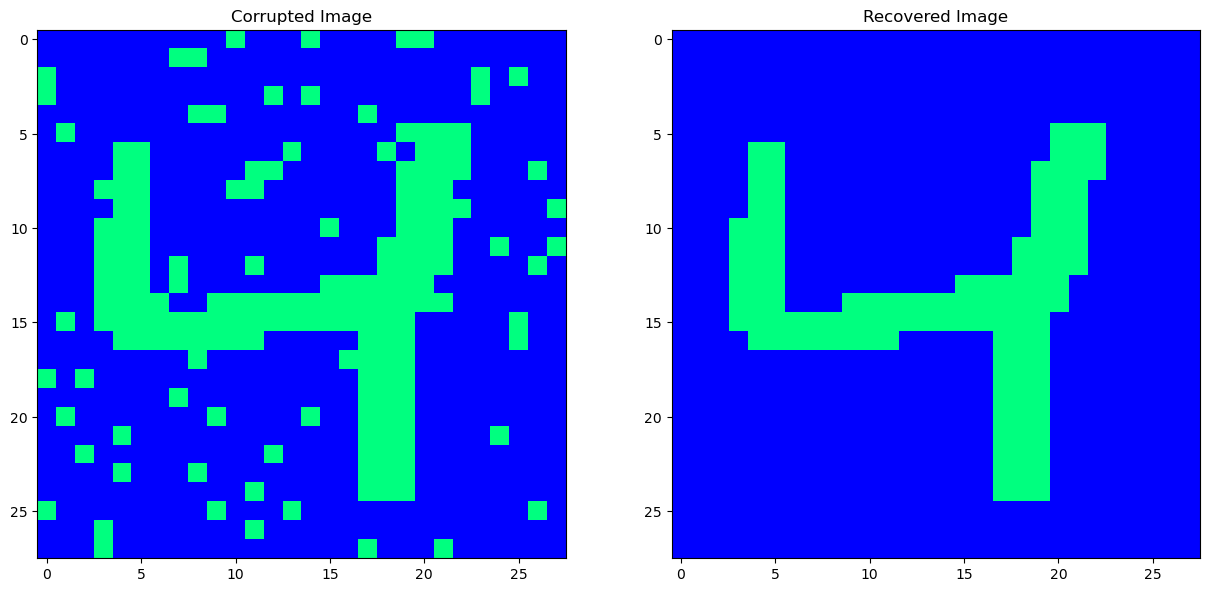

In [24]:
# The number of iterations where we randomly update neurons/pixels
n_iterations = 5000

# Loop through, and recover the image from it's corrupted self.
# energy_vec: This will store the energy of the Hopfield net.
cleaned_image, energy_vec = net.async_recover(corrupted_image, n_iterations, True)

# (For imaging purposes)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7.5))
ax[0].imshow(corrupted_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[0].set_title('Corrupted Image')
ax[1].imshow(cleaned_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[1].set_title('Recovered Image')
plt.show()

 The Hopfield energy plotted as the recovery iteration index is shown below. We can see that as the recovery process was being run, the total net energy was being decreased.

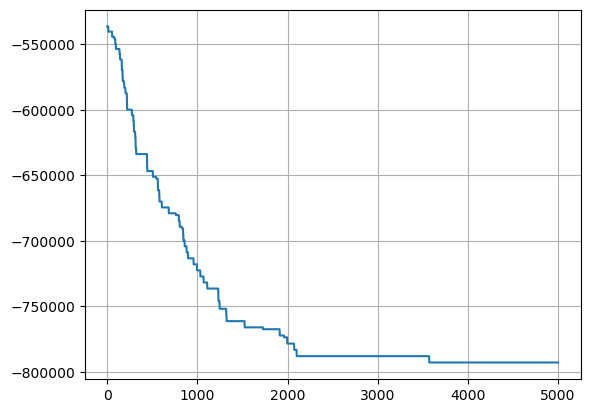

In [25]:
# Plot the Hopfield energy during recovery
plt.plot(bm.as_numpy(energy_vec))
plt.grid('on')
plt.show()

Our original pattern has been very nicely recovered. What about masking noise and bernouli noise? Let's try that.

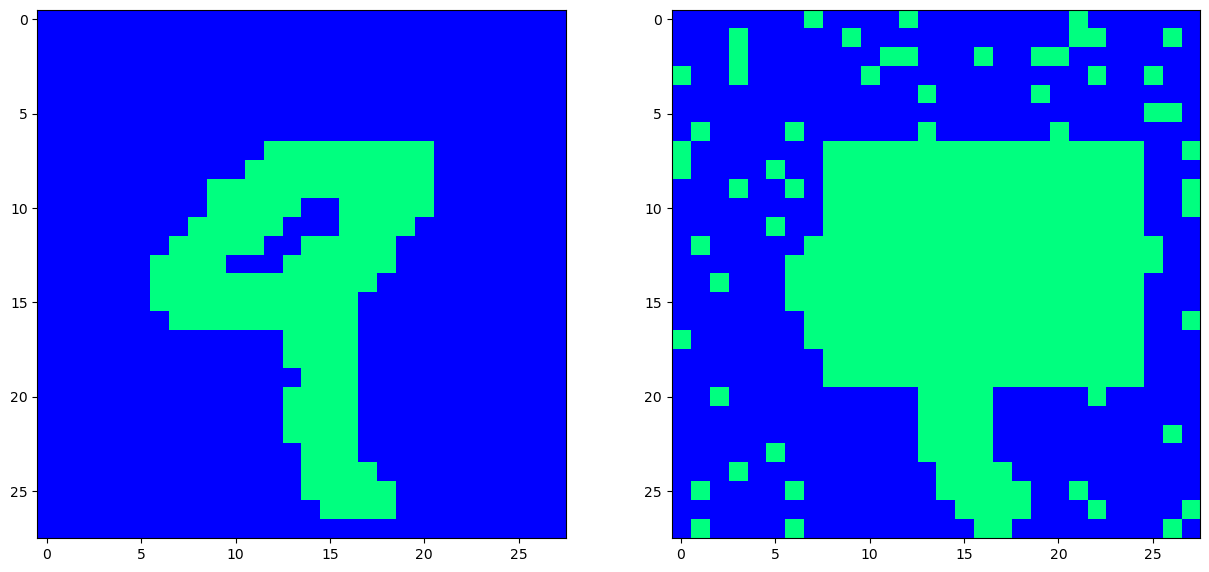

In [26]:
# Masking and Bernouli noise
mask_matrix = np.asarray([[7, 20], [8, 25]], dtype=np.int32)

image = data[0].reshape(28, 28)
corrupted_image = add_mask_noise(image, mask_value=1, mask_matrix=mask_matrix)
corrupted_image = add_bernouli_noise(corrupted_image, prob=0.1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(image, interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image, interpolation='None', cmap='winter')
plt.show()

Now that's one ugly looking '9'. Can we recover the hidden pattern?

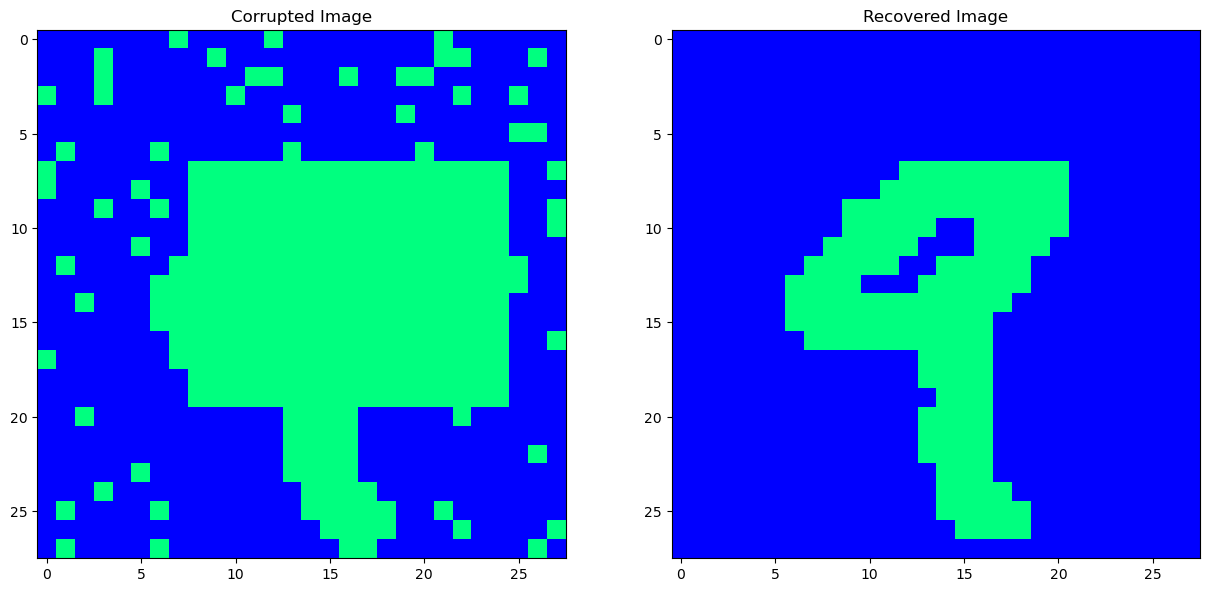

In [27]:
# The number of iterations where we randomly update neurons/pixels
n_iterations = 5000

# Loop through, and recover the image from it's corrupted self.
# energy_vec: This will store the energy of the Hopfield net.
cleaned_image, energy_vec = net.async_recover(corrupted_image.flatten(), n_iterations, True)

# (For imaging purposes)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7.5))
ax[0].imshow(corrupted_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[0].set_title('Corrupted Image')
ax[1].imshow(cleaned_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[1].set_title('Recovered Image')
plt.show()

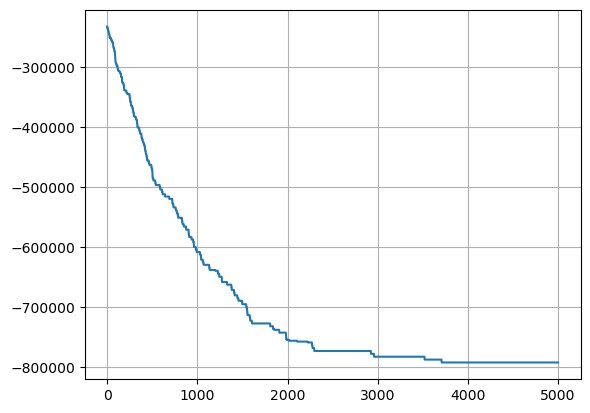

In [28]:
# Plot the Hopfield energy during recovery
plt.plot(bm.as_numpy(energy_vec))
plt.grid('on')
plt.show()

Now this is exactly what it means to be 'content addressable' - the fact that we are able to 'snap back' to a previous pattern among many patterns, starting from a corrupted variant was perhaps one of the first success stories of the associationist movement - Hopefield nets - totally connected RNNs, where the relationships between neurons/pixels are impressed into the weights as minimum energy states. In doing so, the iterative changing of neural activations becomes exactly like finding a configuration of least energy - something that is found in nature all the time.